<a href="https://colab.research.google.com/github/de-developer-1/ml_study/blob/main/ml_try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Library

In [ ]:
!pip install sklearn
!pip install obp


In [ ]:
!pip install obp

In [ ]:
!pip install scipy

In [ ]:
# 必要なパッケージやモジュールをインポート
from sklearn.linear_model import LogisticRegression

from obp.dataset import (
    SyntheticBanditDataset,
    logistic_reward_function,
    linear_behavior_policy
)
from obp.policy import IPWLearner, Random
from obp.ope import (
    OffPolicyEvaluation, 
    RegressionModel,
    InverseProbabilityWeighting as IPS,
    DoublyRobust as DR
)

In [ ]:
# `SyntheticBanditDataset`を用いて人工データを生成する
dataset = SyntheticBanditDataset(
    n_actions=3, # 人工データにおける行動の数
    dim_context=3, # 人工データにおける特徴量の次元数
    reward_function=logistic_reward_function, # 目的変数を生成する関数
    behavior_policy_function=linear_behavior_policy, # 過去の意思決定モデル\pi_bによる行動選択確率を生成する関数
    random_state=12345,
)

# トレーニングデータとバリデーションデータを生成する
training_data = dataset.obtain_batch_bandit_feedback(n_rounds=10000)
validation_data = dataset.obtain_batch_bandit_feedback(n_rounds=10000)

# `training_data`の中身を確認する
training_data

{'action': array([2, 1, 0, ..., 0, 0, 2]), 'action_context': array([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]]), 'context': array([[-0.20470766,  0.47894334, -0.51943872],
        [-0.5557303 ,  1.96578057,  1.39340583],
        [ 0.09290788,  0.28174615,  0.76902257],
        ...,
        [ 0.42468038,  0.48214752, -0.57647866],
        [-0.51595888, -1.58196174, -1.39237837],
        [-0.74213546, -0.93858948,  0.03919589]]), 'expected_reward': array([[0.52082575, 0.66775068, 0.61761261],
        [0.76047843, 0.79422058, 0.58787262],
        [0.44214588, 0.5228099 , 0.46080062],
        ...,
        [0.35186145, 0.53573516, 0.54080877],
        [0.39942913, 0.54329503, 0.6174165 ],
        [0.54430233, 0.60056731, 0.56493023]]), 'n_actions': 3, 'n_rounds': 10000, 'pi_b': array([[[0.31046875],
         [0.34759217],
         [0.34193909]],
 
        [[0.27233556],
         [0.36713323],
         [0.36053121]],
 
        [[0.31443661],
         [0.36905853],
         [0.31650486]

In [ ]:
%%time
# 「IPWLearner+ロジスティック回帰」を定義
ipw_learner = IPWLearner(
    n_actions=dataset.n_actions,
    base_classifier=LogisticRegression(C=100, random_state=12345)
)

# トレーニングデータを用いて、意思決定意思決定モデルを学習
ipw_learner.fit(
    context=training_data["context"], # 特徴量
    action=training_data["action"], # 過去の意思決定モデル\pi_bによる行動選択
    reward=training_data["reward"], # 観測される目的変数
    pscore=training_data["pscore"], # 過去の意思決定モデル\pi_bによる行動選択確率(傾向スコア)
)

# バリデーションデータに対して行動を選択する
action_choice_by_ipw_learner = ipw_learner.predict(
    context=validation_data["context"],
)

CPU times: user 34 ms, sys: 0 ns, total: 34 ms
Wall time: 35.2 ms


In [ ]:
%%time
# ランダム意思決定モデルを定義
random = Random(n_actions=dataset.n_actions)

# バリデーションデータに対する行動選択確率を計算する
action_choice_by_random = random.compute_batch_action_dist(
    n_rounds=validation_data["n_rounds"]
)

CPU times: user 632 µs, sys: 0 ns, total: 632 µs
Wall time: 512 µs


In [ ]:
%%time
# DR推定量に必要な目的変数予測モデルを得る
# opeモジュールに実装されている`RegressionModel`に好みの機械学習手法を与えば良い
regression_model = RegressionModel(
    n_actions=dataset.n_actions, # 行動の数
    base_model=LogisticRegression(C=100, random_state=12345), # ロジスティック回帰を使用
)

# `fit_predict`メソッドにより、バリデーションデータにおける期待報酬を推定
estimated_rewards_by_reg_model = regression_model.fit_predict(
    context=validation_data["context"], # 特徴量
    action=validation_data["action"], # 過去の意思決定モデル\pi_bによる行動選択
    reward=validation_data["reward"], # 観測される目的変数
    random_state=12345,
)

CPU times: user 25.4 ms, sys: 17.9 ms, total: 43.3 ms
Wall time: 27.1 ms


In [ ]:
%%time
# DR推定量に必要な目的変数予測モデルを得る
# opeモジュールに実装されている`RegressionModel`に好みの機械学習手法を与えば良い
regression_model = RegressionModel(
    n_actions=dataset.n_actions, # 行動の数
    base_model=LogisticRegression(C=100, random_state=12345), # ロジスティック回帰を使用
)

# `fit_predict`メソッドにより、バリデーションデータにおける期待報酬を推定
estimated_rewards_by_reg_model = regression_model.fit_predict(
    context=validation_data["context"], # 特徴量
    action=validation_data["action"], # 過去の意思決定モデル\pi_bによる行動選択
    reward=validation_data["reward"], # 観測される目的変数
    random_state=12345,
)

CPU times: user 21.7 ms, sys: 18 ms, total: 39.7 ms
Wall time: 41.9 ms


In [ ]:
# 意思決定モデルの性能評価を一気通貫で行うための`OffPolicyEvaluation`を定義する
ope = OffPolicyEvaluation(
    bandit_feedback=validation_data, # バリデーションデータ
    ope_estimators=[IPS(estimator_name="IPS"), DR()] # 使用する推定量
)

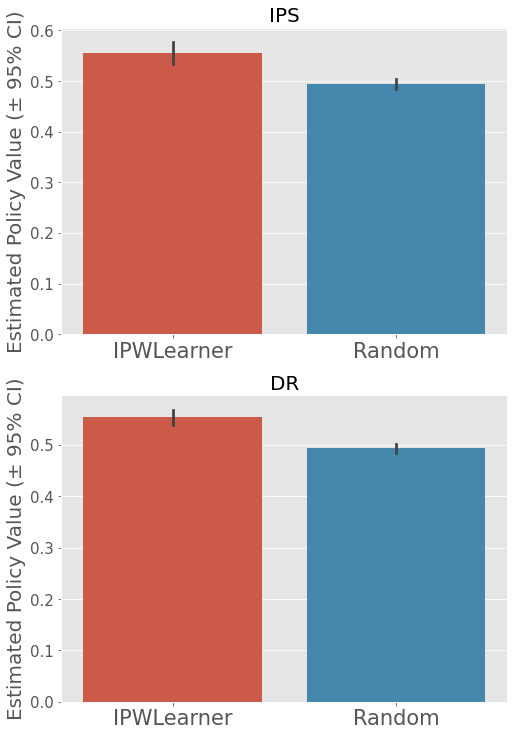

In [ ]:
# IPWLearner+ロジスティック回帰の性能をIPS推定量とDR推定量で評価
ope.visualize_off_policy_estimates_of_multiple_policies(
    policy_name_list=["IPWLearner", "Random"],
    action_dist_list=[
        action_choice_by_ipw_learner, # IPWLearnerによるバリデーションデータに対する行動選択
        action_choice_by_random, # ランダム意思決定モデルによるバリデーションデータに対する行動選択
    ],
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model, # DR推定量に必要な期待報酬推定値
    random_state=12345,
)

In [ ]:
# ipw_learnerとrandomの真の性能を計算する
# これは、`SyntheticBanditDataset`の`cal_ground_truth_policy_value`メソッドを呼び出すことで計算できる
performance_of_ipw_learner = dataset.calc_ground_truth_policy_value(
    expected_reward=validation_data['expected_reward'], # バリデーションデータにおける期待報酬
    action_dist=action_choice_by_ipw_learner, # 評価対象の意思決定モデルによる行動選択確率
)
performance_of_random = dataset.calc_ground_truth_policy_value(
    expected_reward=validation_data['expected_reward'], # バリデーションデータにおける期待報酬
    action_dist=action_choice_by_random, # 評価対象の意思決定モデルによる行動選択確率
)

print(f'IPWLearner+ロジスティック回帰の性能: {performance_of_ipw_learner}')
print(f'ランダム意思決定モデルの性能: {performance_of_random}')

IPWLearner+ロジスティック回帰の性能: 0.5598984377089692
ランダム意思決定モデルの性能: 0.5015716585425379
